# PD Analysis

In [7]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [8]:
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Preprocessing

In [9]:
# file directories
workingDirectory = '/home/jenhan/analysis/pd_analysis/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/hg19'
genomes = ['hg19','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirectory = workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
if not os.path.isfile("nameMapping.tsv"):
    nameMappingFile = open("nameMapping.tsv", "w")
    for f in os.listdir(logFilePath):
        for gen in genomes:
            rootName = f.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
        nameMappingFile.write(rootName + '\t' + rootName + '\n')
    nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    treatment = metaDataTokens[2].strip()
    owner = metaDataTokens[4].strip()
#     date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
#     dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
# _sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
_pbc = []
for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile.replace('.star.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
#     pbc = float(data[-1].split()[-1])

    _originalNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)
#     _pbc.append(pbc)
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']

summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()


## Mapping Quality Control

### Plot Distributions of Mapping Statistics

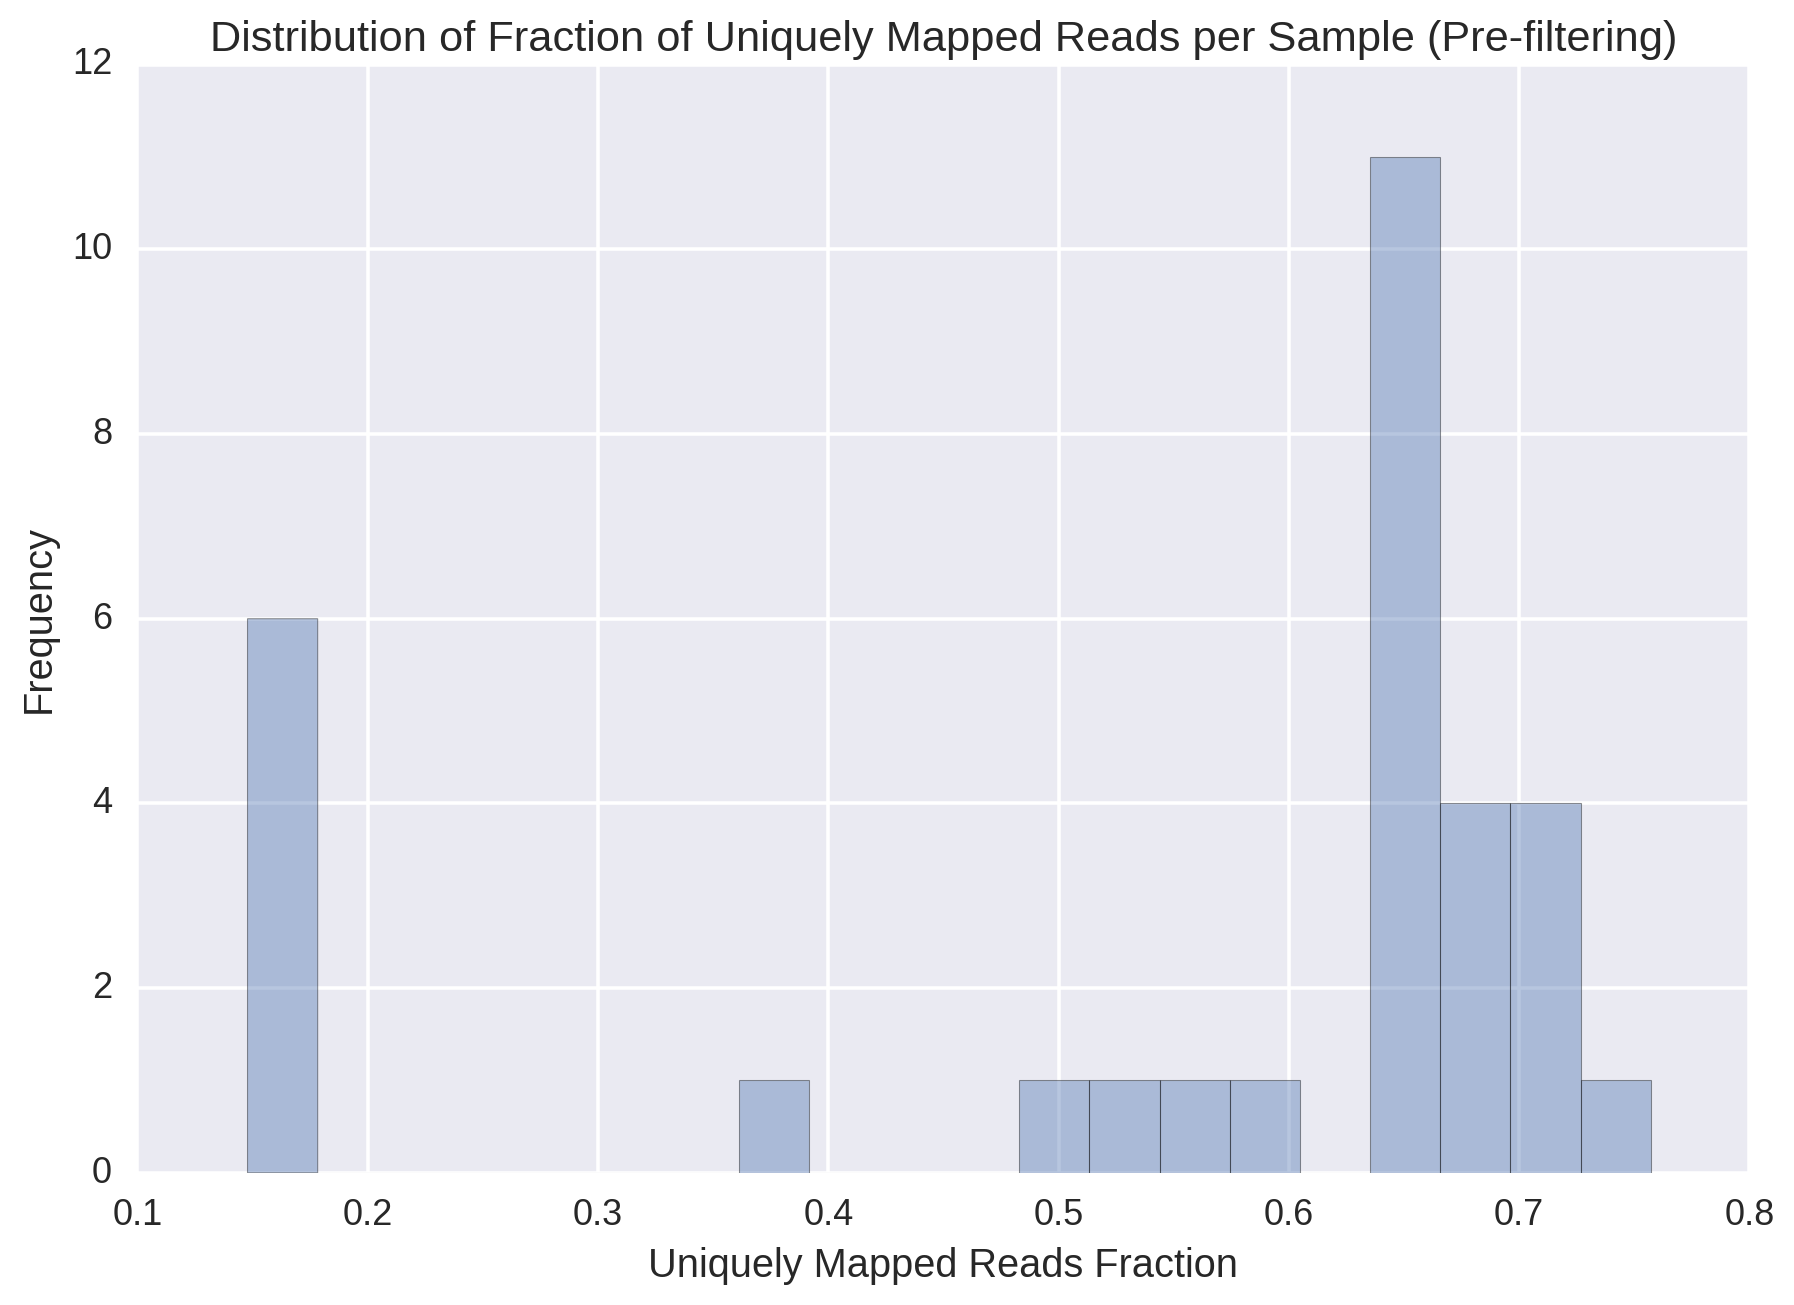

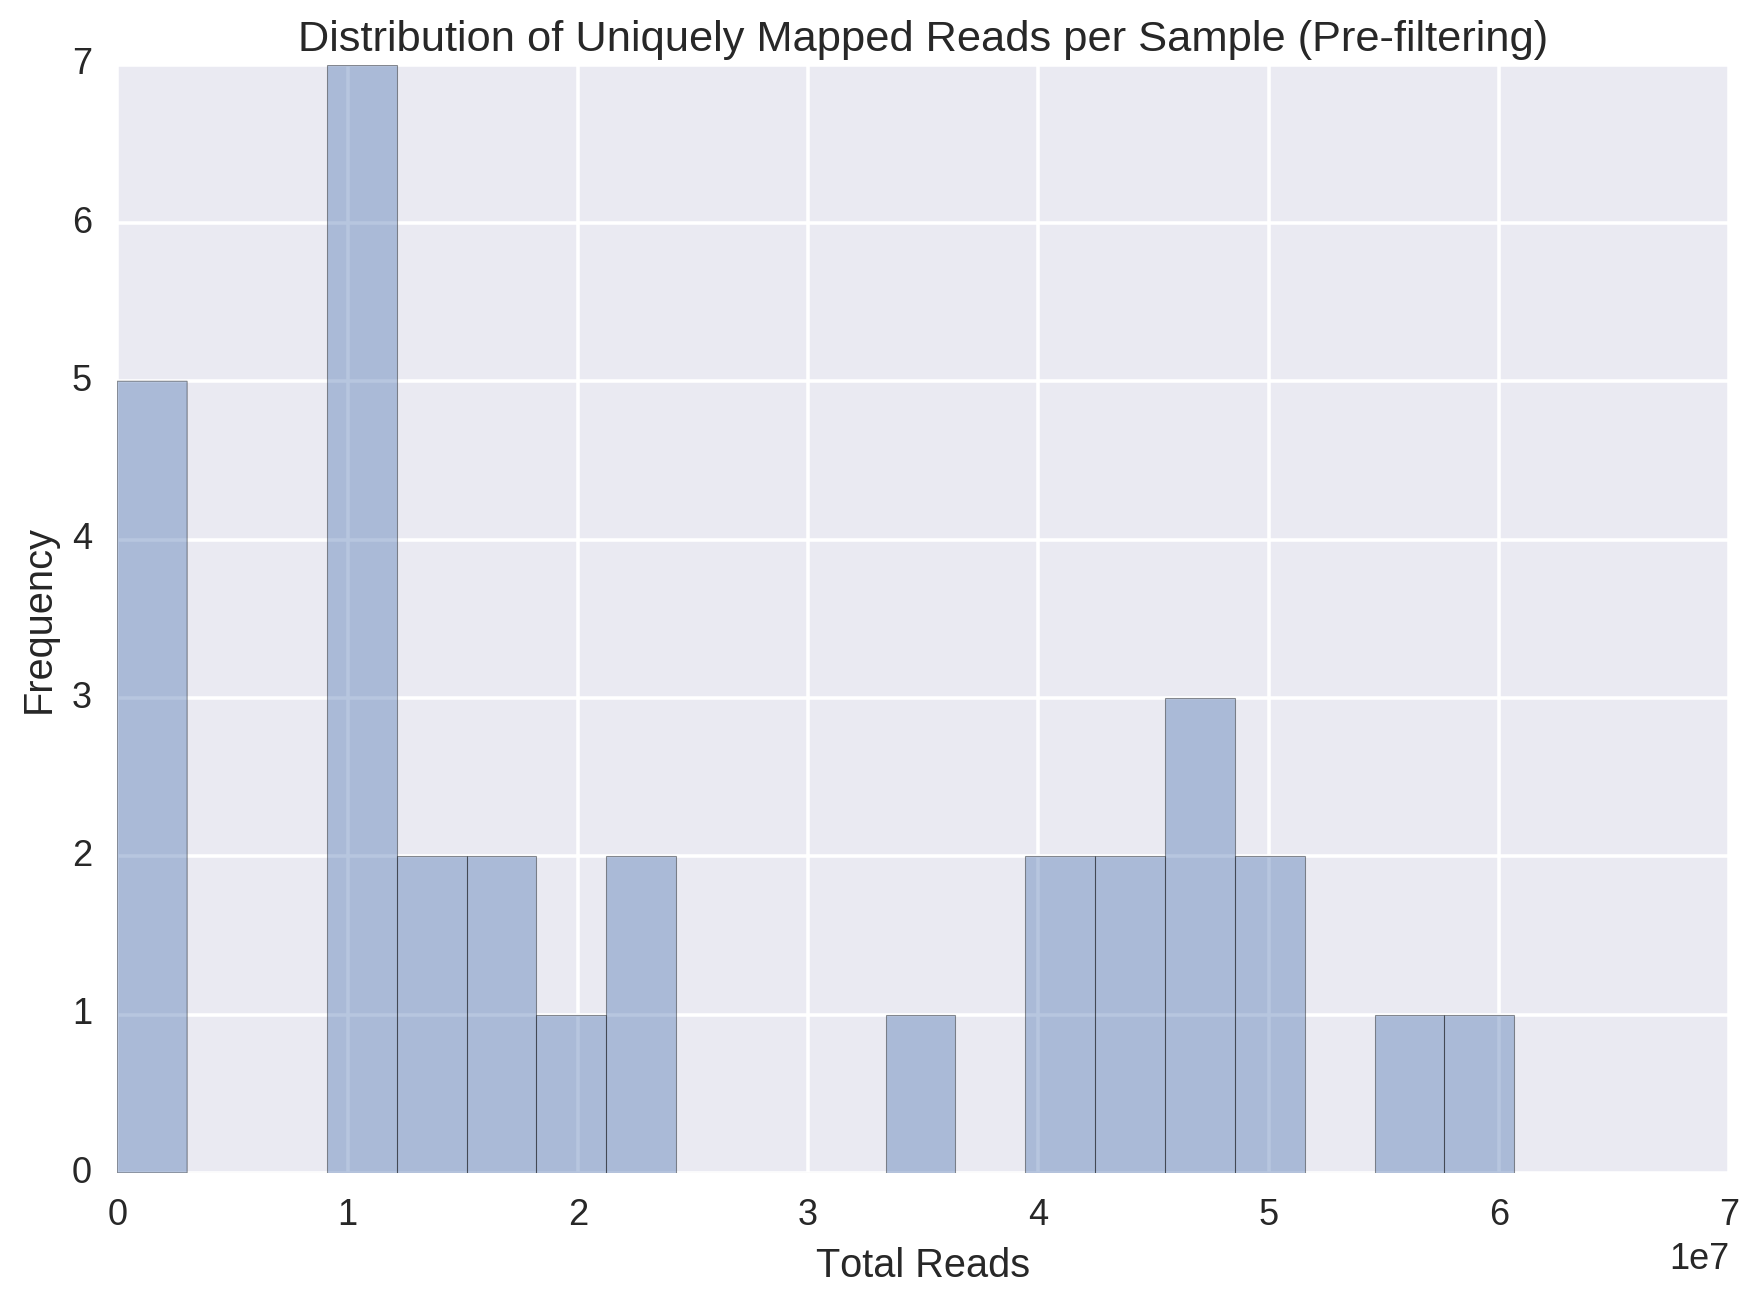

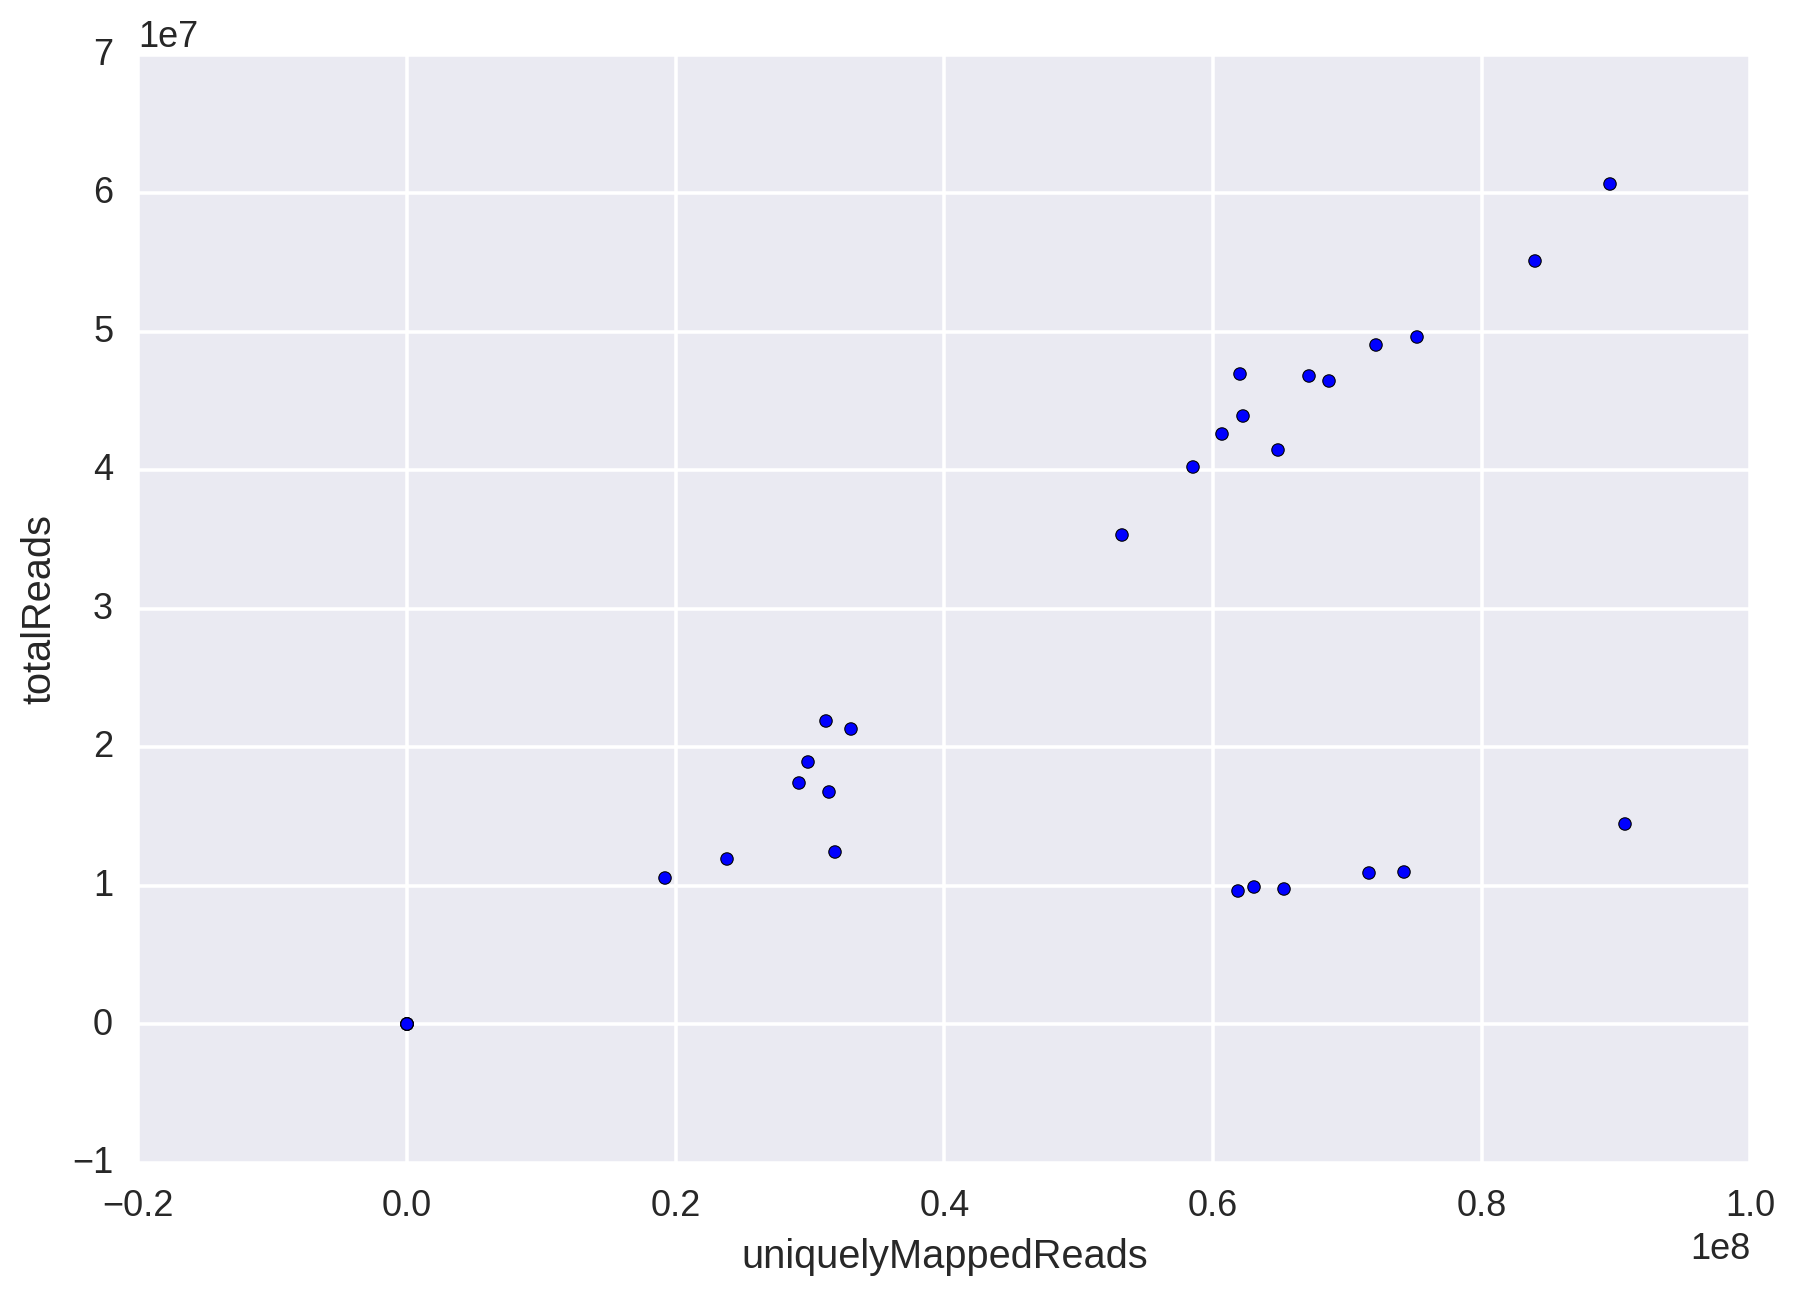

In [10]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()


### Filter Samples According to Mapping Quality

In [11]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.25
uniquelyMappedReadThreshold = 10000000
pbcThreshold=0.0
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]
print(filtered_summary_frame.shape)




# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame["simpleTreatment"]).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 



(20, 12)
Number of Samples: 31
Number of discarded samples: 11
Number of Samples remaining after filtering: 20


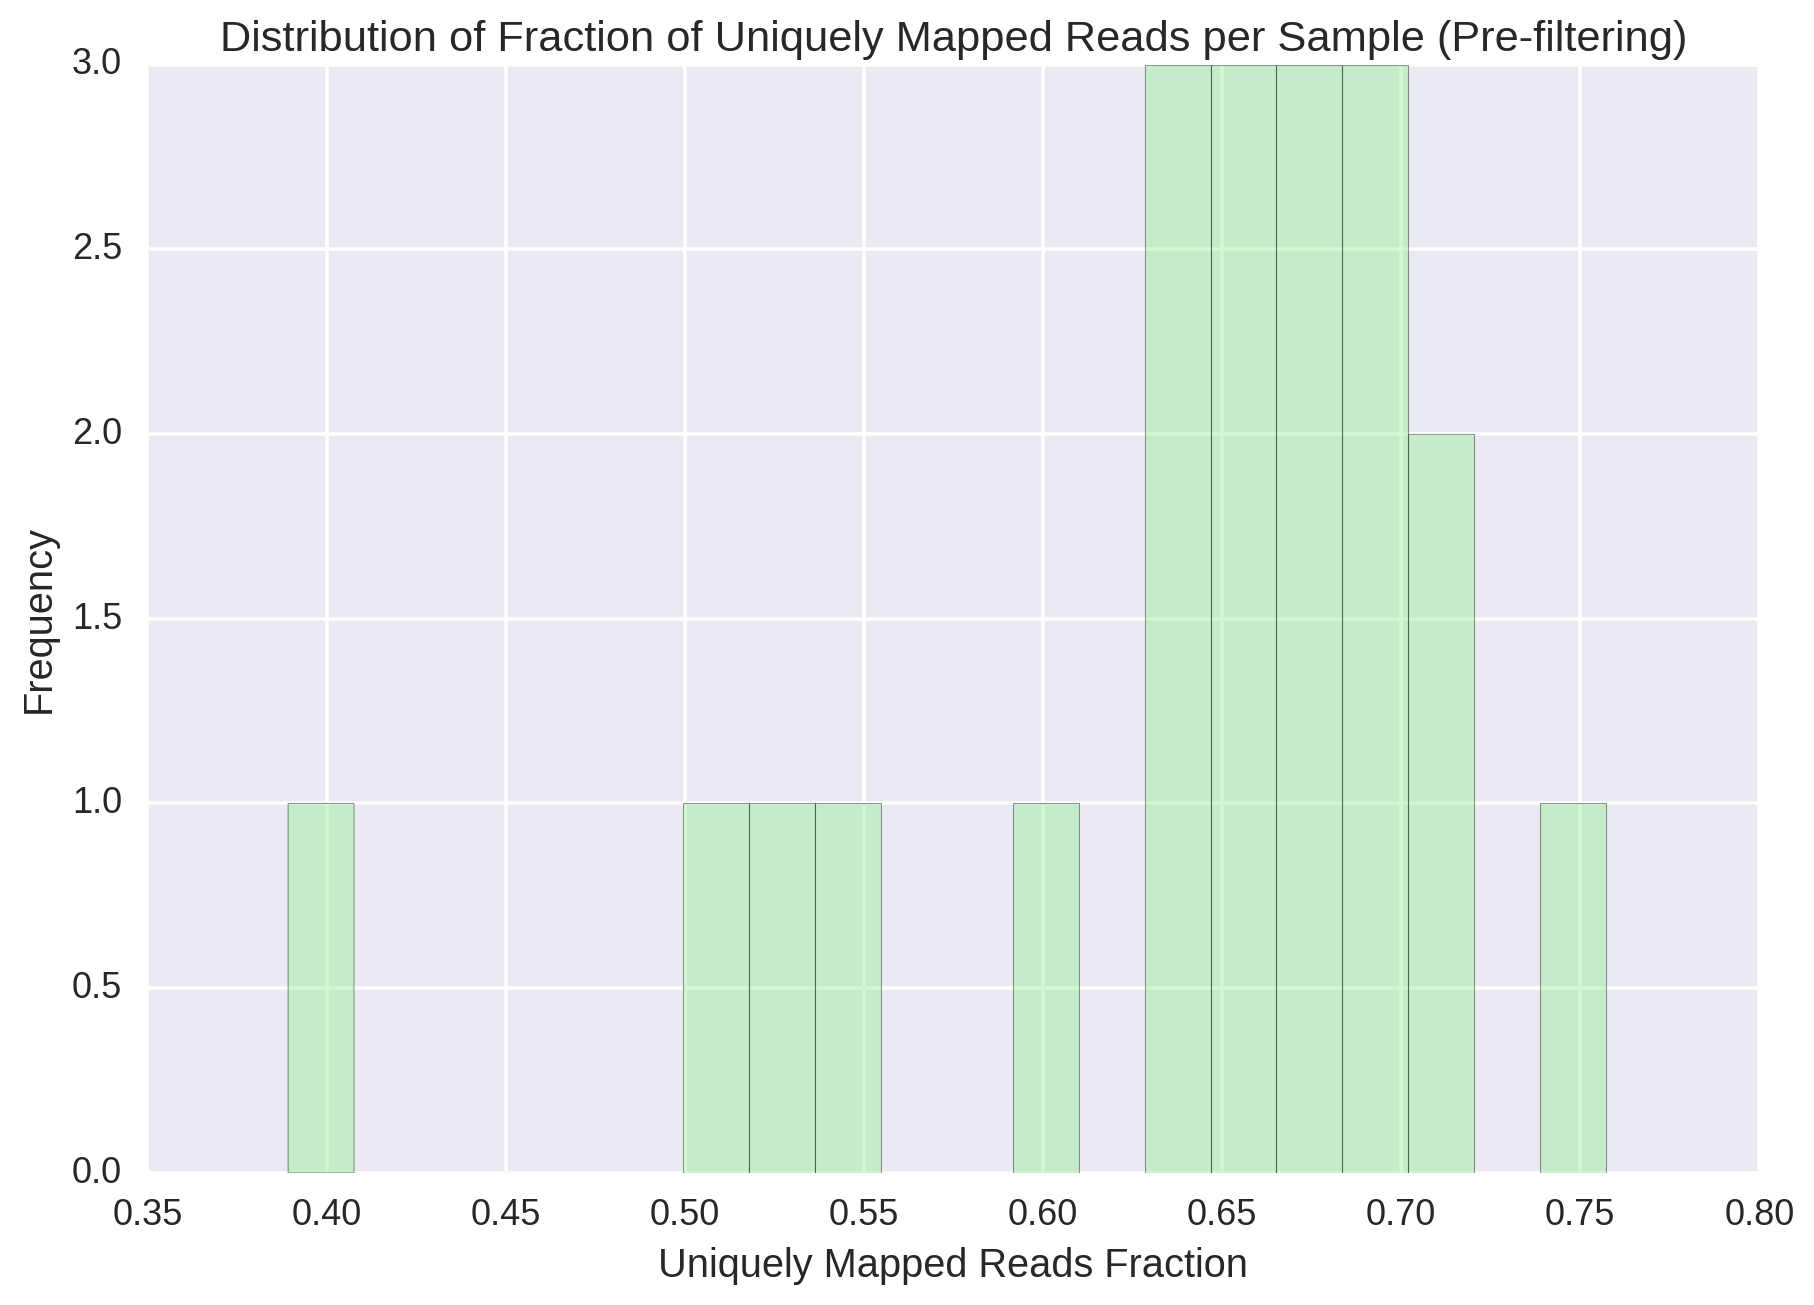

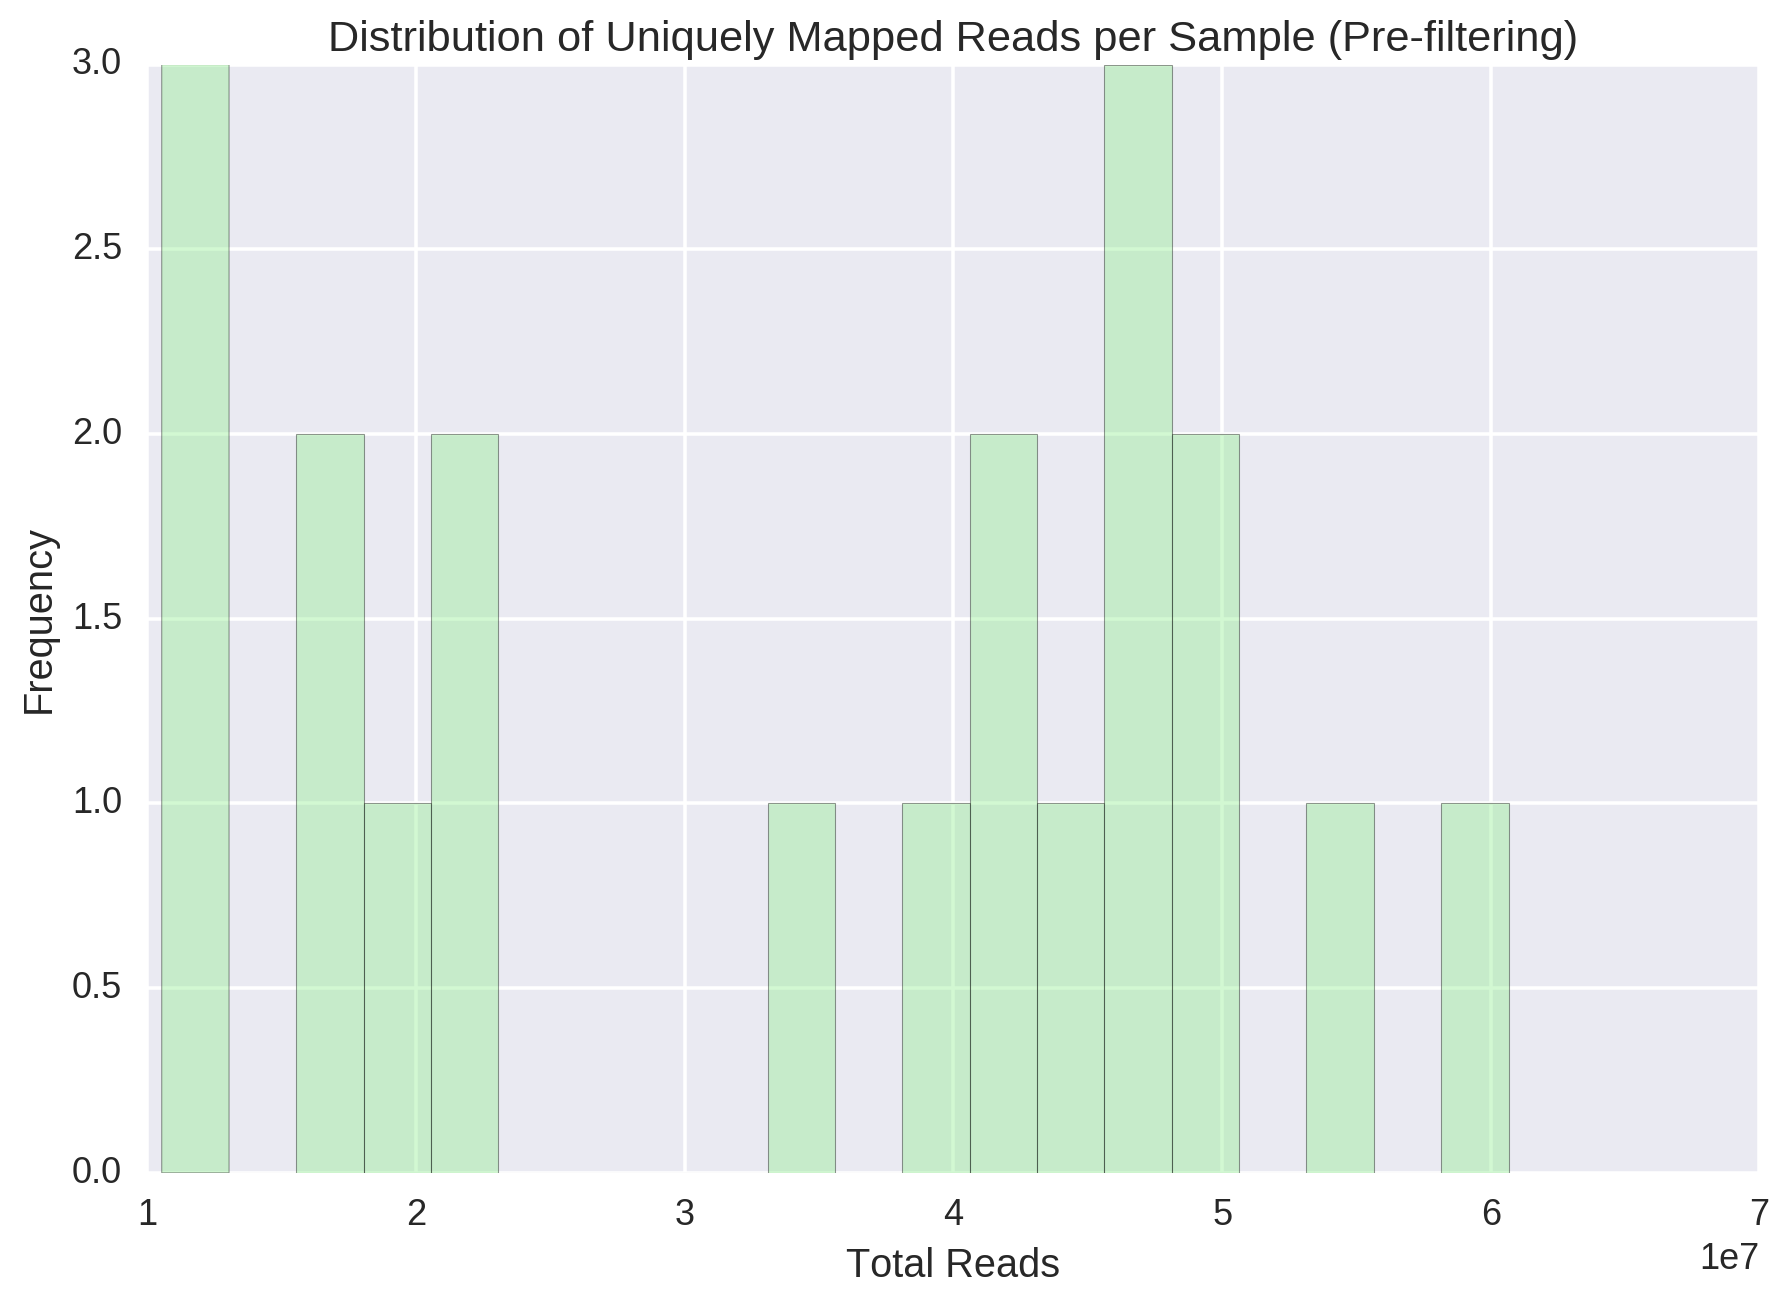

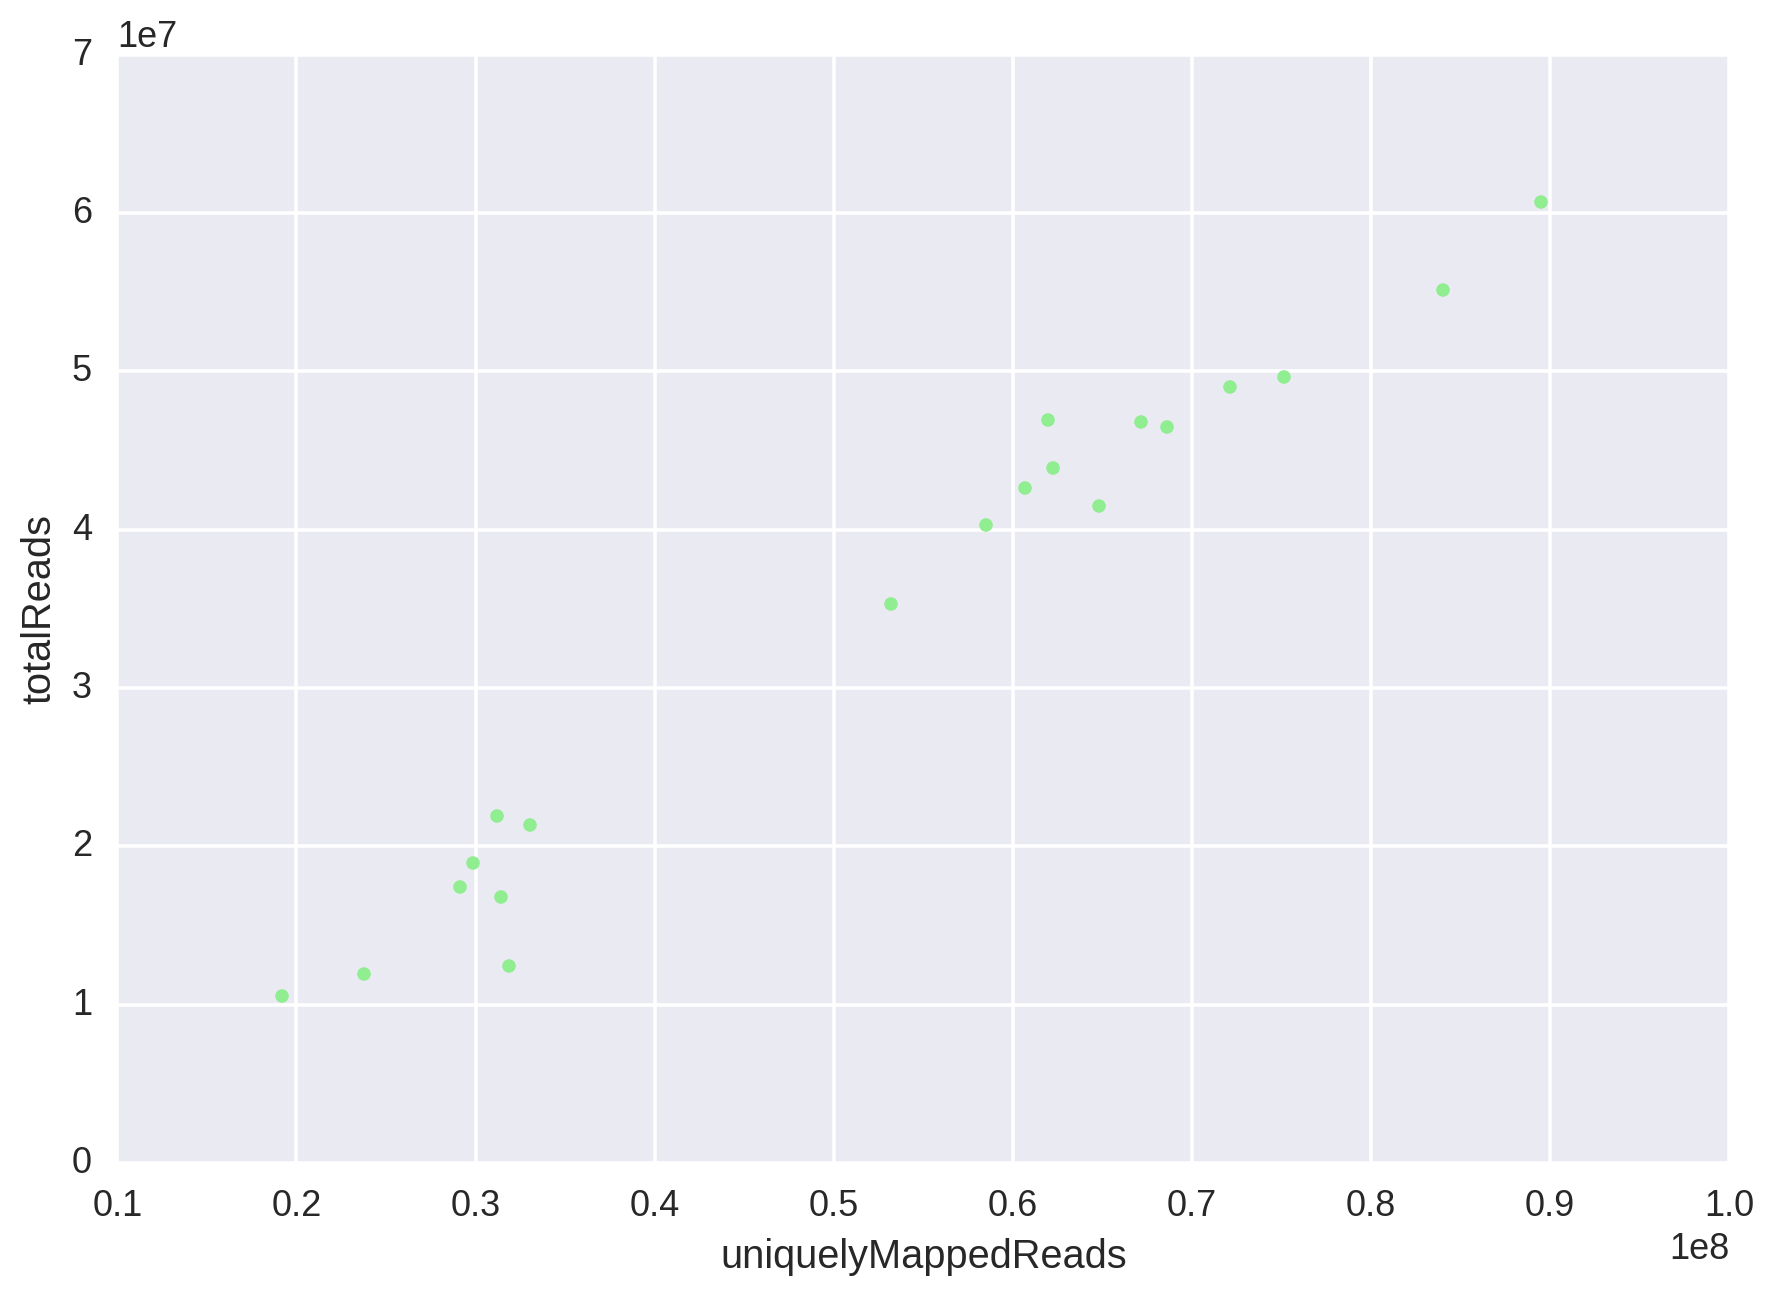

In [12]:
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(filtered_summary_frame['totalReads'], y=filtered_summary_frame['uniquelyMappedReads'], color='lightgreen')
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()






## Calculate Tag Counts and RPKM

In [13]:
%%capture
filteredTagDirectories = ' '.join([tagDirectory +x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna hg19 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/rpkm.tsv
!analyzeRepeats.pl rna hg19 -count exons -condenseGenes -noadj -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/raw.tsv
!analyzeRepeats.pl rna hg19 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/normed.tsv

In [14]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

# read in tag counts
reads_frame = pd.read_csv("normed.tsv",sep="\t")
columns = reads_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
reads_frame.columns = columns  
reads_frame['gene'] = [x.split("|")[0] for x in reads_frame['Annotation/Divergence']]
columns = list(reads_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_frame = reads_frame[columns]

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))


# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 10.0]

# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)



## Run IDR

In [15]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /home/jenhan/analysis/pd_analysis//idr/ Control Control Control Control Control Control Control Control Control Control PD PD PD PD PD PD PD PD PD PD
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Output files will be written to: /home/jenhan/analysis/pd_analysis//idr/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/pd_analysis//tag_directories/Sample_GermanERMo30_RNA_seq_140226 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directories/Sample_GermanERMo48_RNA_seq_140226 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directories/Sample_GermanERMo34_RNA_seq_140226 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag

## Calcuate Differential Expression with EdgeR

In [16]:
%%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x] for x in samples])
! getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv

In [17]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns

## Tag Scatter Plots

In [18]:
# plot scatter plots for the same condition
factor = 4.0
tagCutoff = 0.0
genes = reads_frame['gene'].values
if not os.path.isdir('scatter_plots'):
    os.mkdir('scatter_plots')
# for tag counts
import matplotlib
matplotlib.use('Agg')
simpleNames = list(filtered_summary_frame['simplifiedName'])
treatments = list(filtered_summary_frame['simpleTreatment'])
seenTreatments = set()

for i in range(len(simpleNames) - 1):
    for j in range(i + 1, len(simpleNames)):
        sample1 = simpleName_originalName_dict[simpleNames[i]]
        sample2 = simpleName_originalName_dict[simpleNames[j]]
        treatment1 = treatments[i]
        treatment2 = treatments [j]
        if treatment1 == treatment2:
#             print(simpleNames[i], simpleNames[j])
            currentDir = "scatter_plots/" + treatment1 + "_" + treatment2
            altCurrentDir = "scatter_plots/" + treatment2 + "_" + treatment1
            if altCurrentDir in seenTreatments:
                currentDir = altCurrentDir
            if not currentDir in seenTreatments:
                if not os.path.isdir(currentDir):
                    os.mkdir(currentDir)
                seenTreatments.add(currentDir)
            idrIntersection_frame = pd.read_csv(idrDirectory + '/' +simpleNames[i] + '_' + simpleNames[j] + '_idr.tsv', sep='\t')
            intersecting_refseqs = idrIntersection_frame['refseq']
            current_rpkm_frame = rpkm_frame[rpkm_frame['refseq'].isin(intersecting_refseqs)]
            read_list_1 = current_rpkm_frame[sample1].values
            read_list_2 = current_rpkm_frame[sample2].values
            log_read_list_1 = np.log2(read_list_1 + 0.00000001)
            log_read_list_2 = np.log2(read_list_2 + 0.00000001)

            coords = []
            labels = []
            colors = []
            fig, ax = plt.subplots()
            for x in range(len(read_list_1)):
                foldChange = read_list_1[x]/read_list_2[x]
                if read_list_1[x] >= tagCutoff or read_list_2[x] >= tagCutoff:
                    if foldChange >= factor or foldChange <= 1.0/factor:
                        if read_list_1[x] >= 2 * tagCutoff or read_list_2[x] >=  2 * tagCutoff:
                            labels.append(genes[x])
                            coords.append((log_read_list_1[x],log_read_list_2[x]))
                        colors.append('red')
                    else:
                        colors.append('blue')
                else:
                    colors.append('blue')
            plt.scatter(log_read_list_1,log_read_list_2, c= colors, alpha = 0.5);
            plt.xlabel(simpleNames[i])
            plt.ylabel(simpleNames[j])
            plt.title(sample1 + " VS " + sample2 + " log normed tags")
            plt.ylim(0,max(log_read_list_2))
            plt.xlim(0,max(log_read_list_1))
            for x in range(len(coords)):
                gene = labels[x]
                ax.annotate(gene, xy=coords[x], xytext=(-20,20), size=8,
                        textcoords='offset points', ha='center', va='bottom',
                        bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
            plt.savefig(workingDirectory + "/" + currentDir + "/" + simpleNames[i] + "_" + simpleNames[j] + "_log.pdf")
            plt.close()



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [19]:
# plot scatter plots for different conditions
factor = 2.0
tagCutoff = 1.0

if not os.path.isdir('scatter_plots'):
    os.mkdir('scatter_plots')
# for tag counts
import matplotlib
matplotlib.use('Agg')
simpleNames = list(filtered_summary_frame['simplifiedName'])
treatments = list(filtered_summary_frame['simpleTreatment'])
seenTreatments = set()

for i in range(len(simpleNames) - 1):
    for j in range(i + 1, len(simpleNames)):
        sample1 = simpleName_originalName_dict[simpleNames[i]]
        sample2 = simpleName_originalName_dict[simpleNames[j]]
        treatment1 = treatments[i]
        treatment2 = treatments [j]
        if treatment1 != treatment2:
            print(simpleNames[i], simpleNames[j])
            currentDir = "scatter_plots/" + treatment1 + "_" + treatment2
            altCurrentDir = "scatter_plots/" + treatment2 + "_" + treatment1
            if altCurrentDir in seenTreatments:
                currentDir = altCurrentDir
            if not currentDir in seenTreatments:
                if not os.path.isdir(currentDir):
                    os.mkdir(currentDir)
                seenTreatments.add(currentDir)
            
            idrIntersection_frame_1 = pd.read_csv(idrDirectory + '/' +treatment1 + '_idr_intersection.tsv', sep='\t')
            intersecting_refseqs_1 = set(idrIntersection_frame_1['refseq'].values)
            idrIntersection_frame_2 = pd.read_csv(idrDirectory + '/' +treatment2 + '_idr_intersection.tsv', sep='\t')
            intersecting_refseqs_2 = set(idrIntersection_frame_2['refseq'].values)
            intersecting_refseqs = intersecting_refseqs_1.intersection(intersecting_refseqs_2)
            current_rpkm_frame = rpkm_frame[rpkm_frame['refseq'].isin(intersecting_refseqs)]
            
            genes = current_rpkm_frame['gene'].values
            refseqs = current_rpkm_frame['refseq'].values
           
            read_list_1 = current_rpkm_frame[sample1].values
            read_list_2 = current_rpkm_frame[sample2].values
            log_read_list_1 = np.log2(read_list_1 + 0.00000001)
            log_read_list_2 = np.log2(read_list_2 + 0.00000001)

            coords = []
            labels = []
            colors = []
            fig, ax = plt.subplots()
            geneList_up = open(workingDirectory + "/" + currentDir + "/" + simpleNames[i] + "_" + simpleNames[j] + '_geneList_up.txt', 'w')
            geneList_down = open(workingDirectory + "/" + currentDir + "/" + simpleNames[i] + "_" + simpleNames[j] + '_geneList_down.txt', 'w')


            for x in range(len(read_list_1)):
                foldChange = read_list_1[x]/read_list_2[x]
                if read_list_1[x] >= tagCutoff or read_list_2[x] >= tagCutoff:
                    if foldChange >= factor or foldChange <= 1.0/factor:
                        if read_list_1[x] >= 2 * tagCutoff or read_list_2[x] >=  2 * tagCutoff:
                            labels.append(genes[x])
                            if foldChange >= factor:
                                geneList_up.write(refseqs[x] +'\n')
                            if foldChange <= 1.0/factor:
                                geneList_down.write(refseqs[x] +'\n')
                            coords.append((log_read_list_1[x],log_read_list_2[x]))
                        colors.append('red')
                    else:
                        colors.append('blue')
                else:
                    colors.append('blue')
            plt.scatter(log_read_list_1,log_read_list_2, c= colors, alpha = 0.5);
            plt.xlabel(simpleNames[i])
            plt.ylabel(simpleNames[j])
            plt.title(simpleNames[i] + " VS " + simpleNames[j] + " log rpkm")
            plt.ylim(0,max(log_read_list_2))
            plt.xlim(0,max(log_read_list_1))
            for x in range(len(coords)):
                gene = labels[x]
                ax.annotate(gene, xy=coords[x], xytext=(-20,20), size=8,
                        textcoords='offset points', ha='center', va='bottom',
                        bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
            plt.savefig(workingDirectory + "/" + currentDir + "/" + simpleNames[i] + "_" + simpleNames[j] + "_log.pdf")
            plt.close()
            geneList_up.close()
            geneList_down.close()




Control_1 PD_1


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


OSError: File b'/home/jenhan/analysis/pd_analysis//idr//Control_idr_intersection.tsv' does not exist

In [ ]:
# %%capture
# plot meta scatter plots for different conditions
factor = 2.0
tagCutoff = 0.0

# for tag counts
treatments = sorted(list(set(list(filtered_summary_frame['simpleTreatment']))))
seenTreatments = set()

for i in range(len(treatments) - 1):
    for j in range(i + 1, len(treatments)):

        treatment1 = treatments[i]
        treatment2 = treatments [j]
        currentDir = "scatter_plots/" + treatment1 + "_" + treatment2
        altCurrentDir = "scatter_plots/" + treatment2 + "_" + treatment1
        if altCurrentDir in seenTreatments:
            currentDir = altCurrentDir
        if not currentDir in seenTreatments:
            if not os.path.isdir(currentDir):
                os.mkdir(currentDir)
            seenTreatments.add(currentDir)

        idrIntersection_frame_1 = pd.read_csv(idrDirectory + '/' +treatment1 + '_idrIntersection.tsv', sep='\t')
        intersecting_refseqs_1 = set(idrIntersection_frame_1['refseq'].values)
        idrIntersection_frame_2 = pd.read_csv(idrDirectory + '/' +treatment2 + '_idrIntersection.tsv', sep='\t')
        intersecting_refseqs_2 = set(idrIntersection_frame_2['refseq'].values)
        intersecting_refseqs = intersecting_refseqs_1.intersection(intersecting_refseqs_2)
        
        
        current_rpkm_frame = idrIntersection_frame_1.merge(idrIntersection_frame_2, on='refseq')
        current_rpkm_frame['gene'] = [refseq_gene_mapping[x] for x in current_rpkm_frame['refseq'].values]
        genes = current_rpkm_frame['gene'].values
        refseqs = current_rpkm_frame['refseq'].values

        read_list_1 = np.array([np.mean([float(y) for y in x.split(',')]) for x in current_rpkm_frame['count_x'].values])
        read_list_2 = np.array([np.mean([float(y) for y in x.split(',')]) for x in current_rpkm_frame['count_y'].values])
        log_read_list_1 = np.log2(read_list_1 + 0.00000001)
        log_read_list_2 = np.log2(read_list_2 + 0.00000001)

        coords = []
        labels = []
        colors = []
        fig, ax = plt.subplots()
        meta_geneList_up = []
        meta_geneList_down = []
        foldChanges = []
        for x in range(len(read_list_1)):
            foldChange = read_list_1[x]/read_list_2[x]
            if read_list_1[x] >= tagCutoff or read_list_2[x] >= tagCutoff:
                if foldChange >= factor or foldChange <= 1.0/factor:
                    if read_list_1[x] >= 2 * tagCutoff or read_list_2[x] >=  2 * tagCutoff:
                        labels.append(genes[x])
                        if foldChange >= factor:
                            foldChanges.append(foldChange)
                            meta_geneList_up.append(refseqs[x])
                        if foldChange <= 1.0/factor:
                            foldChanges.append(-1.0/foldChange)
                            meta_geneList_down.append(refseqs[x])
                        coords.append((log_read_list_1[x],log_read_list_2[x]))
                    colors.append('red')
                else:
                    colors.append('blue')
            else:
                colors.append('blue')
        plt.scatter(log_read_list_1,log_read_list_2, c= colors, alpha = 0.5);
        plt.xlabel(treatment1)
        plt.ylabel(treatment2)
        plt.title(treatment1 + " VS " + treatment2 + " log rpkm")
        plt.ylim(0,max(log_read_list_2))
        plt.xlim(0,max(log_read_list_1))
        for x in range(len(coords)):
            gene = labels[x]
            ax.annotate(gene, xy=coords[x], xytext=(-20,20), size=8,
                    textcoords='offset points', ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
        plt.savefig(workingDirectory + "/" + currentDir + "/" +treatment1 + '_' + treatment2 + "_merged_log.pdf")
        plt.show()
     
        
        
        

In [ ]:
# compare edgeR genes and IDR fold change genes
sigDiffExpression_frame = \
    diffExpression_frame[\
                         (diffExpression_frame['Control vs. PD PValue'] <0.05) & \
                         (diffExpression_frame['Control vs. PD FDR'] <0.05) \
                         ]

venn2([set(sigDiffExpression_frame['refseq'].values), set(meta_geneList_up).union(set(meta_geneList_down))], set_labels=['EdgeR','IDR 2fold'])

plt.violinplot([2**x if x > 0.0 else -(2**(-x)) for x in sigDiffExpression_frame['Control vs. PD logFC'].values ],
               showextrema=False)
plt.show()
plt.violinplot(foldChanges, showextrema=False)


In [ ]:
numControls = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == 'Control'].shape[0]
numPDs = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == 'PD'].shape[0]


control_matrix = np.zeros((numControls,numControls))
pd_matrix = np.zeros((numPDs,numPDs))

for out in os.listdir('idr'):
    if out.endswith('.out'):
        with open('./idr/'+out) as f:
            data = f.readlines()
        tokens = out.split('_')
        condition = tokens[0]
        ind1 = int(tokens[1]) - 1
        ind2 = int(tokens[3]) -1
        numGenes = len(data)
        if condition == 'PD':
            pd_matrix[ind1][ind2] = numGenes
            pd_matrix[ind2][ind1] = numGenes
        else:
            control_matrix[ind1][ind2] = numGenes
            control_matrix[ind2][ind1] = numGenes
labels = ['control_'+str(x + 1) for x in range(len(control_matrix))]
sns.clustermap(control_matrix, xticklabels  = labels, yticklabels = labels)
plt.title('Number of Shared IDR Genes for Control Samples' )
plt.show()

labels = ['pd_'+str(x+1) for x in range(len(pd_matrix))]
sns.clustermap(pd_matrix, xticklabels  = labels, yticklabels = labels )
plt.title('Number of Shared IDR Genes for Case Samples' )
plt.show()

In [ ]:
pd_intersection_frame = pd.read_csv(idrDirectory + '/PD_idrIntersection.tsv', sep='\t')
pd_union_frame = pd.read_csv(idrDirectory + '/PD_idrUnion.tsv', sep='\t')
control_intersection_frame = pd.read_csv(idrDirectory + '/Control_idrIntersection.tsv', sep='\t')
control_union_frame = pd.read_csv(idrDirectory + '/Control_idrUnion.tsv', sep='\t')


In [ ]:
pd_union_genes = set(pd_union_frame['refseq'].values)
control_union_genes = set(control_union_frame['refseq'].values)
pd_intersection_genes = set(pd_intersection_frame['refseq'].values)
control_intersection_genes = set(control_intersection_frame['refseq'].values)

venn2([control_union_genes,pd_union_genes], set_labels=['control', 'PD'])
plt.title('Overlap of IDR Union Genes')
plt.show()

venn2([control_intersection_genes,pd_intersection_genes], set_labels=['control', 'PD'])
plt.title('Overlap of IDR Intersection Genes')
plt.show()

venn2([pd_intersection_genes,pd_union_genes], set_labels=['intersection', 'union'])
plt.title('Overlap of PD IDR Genes')
plt.show()

venn2([control_intersection_genes,control_union_genes], set_labels=['intersection', 'union'])
plt.title('Overlap of Control IDR Genes')
plt.show()

In [ ]:
# show distribution of rpkm values
pd_union_rpkm = np.array([np.mean([float(y) for y in x.split(',')]) for x in pd_union_frame['count']]).flatten()
log_pd_union_rpkm = np.log2(pd_union_rpkm)
minVal = np.min(log_pd_union_rpkm[log_pd_union_rpkm != -np.inf])
log_pd_union_rpkm[log_pd_union_rpkm == -np.inf] = minVal

pd_intersection_rpkm = np.array([np.mean([float(y) for y in x.split(',')]) for x in pd_intersection_frame['count']]).flatten()
log_pd_intersection_rpkm = np.log2(pd_intersection_rpkm)
minVal = np.min(log_pd_intersection_rpkm[log_pd_intersection_rpkm != -np.inf])
log_pd_intersection_rpkm[log_pd_intersection_rpkm == -np.inf] = minVal

control_union_rpkm = np.array([np.mean([float(y) for y in x.split(',')]) for x in control_union_frame['count']]).flatten()
log_control_union_rpkm = np.log2(control_union_rpkm)
minVal = np.min(log_control_union_rpkm[log_control_union_rpkm != -np.inf])
log_control_union_rpkm[log_control_union_rpkm == -np.inf] = minVal

control_intersection_rpkm = np.array([np.mean([float(y) for y in x.split(',')]) for x in control_intersection_frame['count']]).flatten()
log_control_intersection_rpkm = np.log2(control_intersection_rpkm)
minVal = np.min(log_control_intersection_rpkm[log_control_intersection_rpkm != -np.inf])
log_control_intersection_rpkm[log_control_intersection_rpkm == -np.inf] = minVal

log_rpkm = np.log2(filtered_rpkm_frame.values.flatten())
minVal = np.min(log_rpkm[log_rpkm != -np.inf])
log_rpkm[log_rpkm == -np.inf] = minVal

plt.violinplot([log_rpkm, log_control_union_rpkm, log_pd_union_rpkm, log_control_intersection_rpkm, log_pd_intersection_rpkm],
                showextrema = False)
plt.xticks(np.arange(5)+1, ['all', 'control_union','pd_union', 'control_intersection', 'pd_intersection'], rotation=90)
plt.title('Comparison of IDR RPKM values')
plt.ylabel('RPKM (log2)')

## Clustering

In [ ]:
rpkm_threshold = 10

union_union_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(pd_union_genes.union(control_union_genes))]
union_union_rpkm_frame = union_union_rpkm_frame[union_union_rpkm_frame.sum(axis=1) > rpkm_threshold]

intersection_union_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(pd_union_genes.intersection(control_union_genes))]
intersection_union_rpkm_frame = intersection_union_rpkm_frame[intersection_union_rpkm_frame.sum(axis=1) > rpkm_threshold]

union_intersection_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(pd_intersection_genes.union(control_intersection_genes))]
union_intersection_rpkm_frame = union_intersection_rpkm_frame[union_intersection_rpkm_frame.sum(axis=1) > rpkm_threshold]

intersection_intersection_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(pd_intersection_genes.intersection(control_intersection_genes))]
intersection_intersection_rpkm_frame = intersection_intersection_rpkm_frame[intersection_intersection_rpkm_frame.sum(axis=1) > rpkm_threshold]

# add pseudo count for logging
union_union_rpkm_frame = union_union_rpkm_frame + 1
intersection_union_rpkm_frame = intersection_union_rpkm_frame + 1
union_intersection_rpkm_frame = union_intersection_rpkm_frame + 1
intersection_intersection_rpkm_frame = intersection_intersection_rpkm_frame + 1


In [ ]:
sns.distplot(np.log2(union_union_rpkm_frame.sum(axis=1)))
plt.show()

sns.distplot([x for x in intersection_intersection_rpkm_frame.sum(axis=1).values if x >0])
plt.show()

In [ ]:
p_threshold = 0.01
kw_refseqs = []
pvals = []
kw_genes = []
for refseq in set(filtered_rpkm_plottingFrame['refseq'].values):

    gene = refseq_gene_mapping[refseq]
    currentVals = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['refseq'] == refseq]
    control_vals = currentVals[currentVals['treatment'] == 'Control']['rpkm'].values
    pd_vals = currentVals[currentVals['treatment'] == 'PD']['rpkm'].values

    kws, p = stats.kruskal(control_vals, pd_vals)
    pvals.append(p)
    if p< p_threshold:
#         sns.factorplot(data=currentVals, x='treatment', y='rpkm', kind='box')
#         plt.savefig('./boxplot_genes/' + gene +'_boxplot.png')
        kw_refseqs.append(refseq)
        kw_genes.append(gene)

In [ ]:
kw_genes = [refseq_gene_mapping[x] for x in kw_refseqs]


cg = sns.clustermap(np.log2(intersection_intersection_rpkm_frame[\
        intersection_intersection_rpkm_frame.index.isin(kw_refseqs)]),
        cmap='Blues')
plt.title("Log Kruskal–Wallis")
cg.ax_heatmap.set_yticklabels([]);
        

In [ ]:
genes = [refseq_gene_mapping[x] if x in refseq_gene_mapping else x for x in sigDiffExpression_frame['refseq'].values]
cg = sns.clustermap(np.log2(union_union_rpkm_frame[union_union_rpkm_frame.index.isin(sigDiffExpression_frame['refseq'])]))
cg.ax_heatmap.set_yticklabels(genes);
plt.title("Log EdgeR")


In [ ]:
genes = [refseq_gene_mapping[x] if x in refseq_gene_mapping else x for x in sigDiffExpression_frame['refseq'].values]


cg = sns.clustermap(np.log2(intersection_intersection_rpkm_frame[\
        intersection_intersection_rpkm_frame.index.isin(sigDiffExpression_frame['refseq'].values)]),
        );
plt.title("Log EdgeR IDR")
cg.ax_heatmap.set_yticklabels(genes);
        

## Regressions

In [ ]:
clinical_frame = pd.read_csv('clinical_data.txt',sep='\t')
filtered_clinical_frame = filtered_summary_frame.merge(clinical_frame, on='originalName')
blood_frame = pd.read_csv('ermo_clinical.txt', sep='\t')
columns = blood_frame.columns.values
columns[0]= 'Subject'
blood_frame.columns = columns
clinical_frame = clinical_frame.merge(blood_frame, on='Subject')

filtered_clinical_frame = clinical_frame[clinical_frame['originalName'].isin(originalName_simpleName_dict)]

filtered_clinical_frame['Sample'] = [originalName_simpleName_dict[x] for x in filtered_clinical_frame['originalName']]
# remove non numeric columns
del filtered_clinical_frame['Subject']
del filtered_clinical_frame['originalName']
del filtered_clinical_frame['Sex']
del filtered_clinical_frame['Age of Onset']
del filtered_clinical_frame['side']
del filtered_clinical_frame['H&Y']
del filtered_clinical_frame['First Name']
del filtered_clinical_frame['Surname']

columns = ['Sample'] + list(filtered_clinical_frame.columns.values[:-1])
filtered_clinical_frame = filtered_clinical_frame[columns]
filtered_clinical_frame.to_csv('filtered_clinical_data.tsv',sep='\t',index=False)

In [ ]:
simplifiedName_age_dict = dict(zip(filtered_clinical_frame['simplifiedName'],filtered_clinical_frame['Age']))
simplifiedName_duration_dict = dict(zip(filtered_clinical_frame['simplifiedName'],filtered_clinical_frame['Disease Duration']))
simplifiedName_UPDRS_dict = dict(zip(filtered_clinical_frame['simplifiedName'],filtered_clinical_frame['UPDRS']))

In [ ]:
clinical_plottingFrame = filtered_rpkm_plottingFrame.copy()
# TEMP #
clinical_plottingFrame = clinical_plottingFrame[clinical_plottingFrame['simplifiedName'] != 'PD_1']
# TEMP #
clinical_plottingFrame['age'] = [simplifiedName_age_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['duration'] = [simplifiedName_duration_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['updrs'] = [simplifiedName_UPDRS_dict[x] for x in clinical_plottingFrame['simplifiedName']]

In [ ]:
clinical_vars = []
coefficient_types = []
coefficients = []

for refseq in set(clinical_plottingFrame[clinical_plottingFrame['refseq'].isin(kw_refseqs)]['refseq'].values):
    gene = refseq_gene_mapping[refseq]
    currentVals = clinical_plottingFrame[clinical_plottingFrame['refseq'] == refseq]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients})
sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', showfliers=Fal
se)

In [ ]:
for refseq in spearman_refseqs:
    gene = refseq_gene_mapping[refseq]
    currentVals = clinical_plottingFrame[clinical_plottingFrame['refseq'] == refseq]
    rpkms = currentVals['rpkm'].values
    duration = currentVals['duration'].values
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)
    sns.lmplot(data=currentVals, x='duration', y='rpkm')
    plt.title(gene +' Spearman: '+str(r_spearman)+ ' p: ' +str(p_spearman))
    plt.savefig('./correlation_genes/' +gene+'_correlation.png')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state
# Next line to silence pyflakes.
fig=plt.figure()
# ax = fig.gca(projection='3d')
# Perform t-distributed stochastic neighbor embedding.
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(np.log2(filtered_rpkm_frame[filtered_rpkm_frame.index.isin(kw_refseqs)]+1).T).T

colors = ['red' if 'PD' in x else 'blue' for x in filtered_rpkm_frame.columns]
# ax.scatter(trans_data[0],trans_data[1], c=colors)
plt.scatter(trans_data[0],trans_data[1], c=colors)


plt.show()

In [ ]:
# create RPKM tables for WGCNA
idr_refseqs = set(pd_intersection_frame['refseq'].values).intersection(set(control_intersection_frame['refseq'].values))
idr_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(idr_refseqs)]

idr_rpkm_frame['refseq'] = idr_rpkm_frame.index.values
idr_rpkm_frame['gene'] = [refseq_gene_mapping[x] for x in idr_rpkm_frame.index.values]

columns = ['refseq','gene'] + list(idr_rpkm_frame.columns.values[:-2])
idr_rpkm_frame = idr_rpkm_frame[columns]

idr_rpkm_frame.to_csv('idr_rpkm.tsv', sep='\t', index=False)


In [ ]:
# create RPKM tables for WGCNA
idr_refseqs = set(pd_intersection_frame['refseq'].values).intersection(set(control_intersection_frame['refseq'].values))
idr_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(idr_refseqs)]

idr_rpkm_frame['refseq'] = idr_rpkm_frame.index.values
idr_rpkm_frame['gene'] = [refseq_gene_mapping[x] for x in idr_rpkm_frame.index.values]

columns = ['refseq','gene'] + list(idr_rpkm_frame.columns.values[:-2])
idr_rpkm_frame = idr_rpkm_frame[columns]
del idr_rpkm_frame['PD_1']
idr_rpkm_frame.to_csv('idr_rpkm.tsv', sep='\t', index=False)

